# Step 0 — Imports & Display Settings
This cell imports core Python libraries and scikit-learn tools that we will use throughout the notebook. It also configures display options for clearer outputs.

In [21]:
# === Step 0: Imports & display settings ===
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)
print("Libraries imported.")

Libraries imported.


# Step 2 — Identify Column Types
This cell separates **numeric** and **text** columns. We will apply different preprocessing to each type.

In [22]:
# === Step 1: Load data ===
# Make sure the file 'Ames_Housing_Data.csv' is in the same directory as this notebook.
# If your file is elsewhere, update the path accordingly.
csv_path = "Ames_Housing_Data.csv"
df = pd.read_csv(csv_path)
print("Data loaded:", df.shape)
df.head(10)

Data loaded: (2930, 81)


,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,NaN,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
5,527105030,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195500
6,527127150,120,RL,41.0,4920,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,2001,2001,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,616.0,Unf,0.0,722.0,1338.0,GasA,Ex,Y,SBrkr,1338,0,0,1338,1.0,0.0,2,0,2,1,Gd,6,Typ,0,NaN,Attchd,2001.0,Fin,2.0,582.0,TA,TA,Y,0,0,170,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,213500
7,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,191500
8,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1995,1996,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,1180.0,Unf,0.0,415.0,1595.0,GasA,Ex,Y,SBrkr,1616,0,0,1616,1.0,0.0,2,0,2,1,Gd,5,Typ,1

# Step 3 — Clean Data: Imputation
This cell imputes missing values: **median** for numeric columns and **most_frequent** for categoricals.

In [23]:
# === Step 2: Identify numeric and textual columns ===
numeric_columns = df.select_dtypes(include=["number"]).columns.tolist()
text_columns    = df.select_dtypes(include=["object"]).columns.tolist()

print(f"Numeric columns ({len(numeric_columns)}):", numeric_columns[:10], "...")
print(f"Text columns ({len(text_columns)}):", text_columns[:10], "...")

Numeric columns (38): ['PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1'] ...
Text columns (43): ['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1'] ...


# Step 3 — Clean Data: One-Hot Encoding
This cell one-hot encodes categorical features with `pandas.get_dummies` so that models can consume text features.

In [24]:
def clean_outliers(df_in: pd.DataFrame, method: str = "cap", k: float = 1.5):
    df_clean = df_in.copy()
    for col in df_clean.select_dtypes(include="number").columns:
        s = df_clean[col]
        if s.notna().sum() == 0:
            continue
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        low, up = q1 - k * iqr, q3 + k * iqr
        if method == "cap":
            df_clean[col] = s.clip(lower=low, upper=up)
        elif method == "median":
            mask = (s < low) | (s > up)
            df_clean.loc[mask, col] = s.median()
        elif method == "remove":
            mask = (s < low) | (s > up)
            df_clean = df_clean.loc[~mask]
    return df_clean


# Step 4 — Quick Checks & (Optional) Save
This cell verifies there are no remaining missing values in the cleaned dataset and optionally saves it to disk.

In [25]:
# === Step 3: Clean data ===
# 3.1 Impute missing values
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

df_num = df[numeric_columns].copy()
df_cat = df[text_columns].copy()

num_imputed = pd.DataFrame(num_imputer.fit_transform(df_num), columns=numeric_columns, index=df.index)
cat_imputed = pd.DataFrame(cat_imputer.fit_transform(df_cat), columns=text_columns, index=df.index)


# Step 5 — Forecast SalePrice (Setup)
This cell imports evaluation metrics and model classes used for regression benchmarking.

In [26]:

# 3.2 Outlier capping (after numeric imputation)
num_capped = clean_outliers(num_imputed, method="cap", k=1.5)


In [27]:
# 3.3 One-hot encode categoricals with pandas.get_dummies
cat_encoded = pd.get_dummies(cat_imputed, drop_first=False)


cat_encoded 

,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Utilities_NoSewr,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Artery,Condition 1_Feedr,...,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Fireplace Qu_Ex,Fireplace Qu_Fa,Fireplace Qu_Gd,Fireplace Qu_Po,Fireplace Qu_TA,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Finish_Fin,Garage Finish_RFn,Garage Finish_Unf,Garage Qual_Ex,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_Po,Garage Qual_TA,Garage Cond_Ex,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_Po,Garage Cond_TA,Paved Drive_N,Paved Drive_P,Paved Drive_Y,Pool QC_Ex,Pool QC_Fa,Pool QC_Gd,Pool QC_TA,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Misc Feature_Elev,Misc Feature_Gar2,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,False,False,False,False,False,True,False,False,True,True,False,True,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
1,False,False,False,False,True,False,False,False,True,True,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
2,False,False,False,False,False,True,False,False,True,True,False,True,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,Fals

In [28]:
# 3.4 Scale numeric columns
scaler = StandardScaler()
num_scaled_arr = scaler.fit_transform(num_capped)
num_scaled = pd.DataFrame(num_scaled_arr, columns=numeric_columns, index=df.index)

# 3.5 Assemble the final cleaned dataset
cleaned_df = pd.concat([num_scaled, cat_encoded], axis=1)
print("Cleaned shape:", cleaned_df.shape)
cleaned_df.head(10)

Cleaned shape: (2930, 305)


,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Utilities_NoSewr,...,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Fireplace Qu_Ex,Fireplace Qu_Fa,Fireplace Qu_Gd,Fireplace Qu_Po,Fireplace Qu_TA,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Finish_Fin,Garage Finish_RFn,Garage Finish_Unf,Garage Qual_Ex,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_Po,Garage Qual_TA,Garage Cond_Ex,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_Po,Garage Cond_TA,Paved Drive_N,Paved Drive_P,Paved Drive_Y,Pool QC_Ex,Pool QC_Fa,Pool QC_Gd,Pool QC_TA,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Misc Feature_Elev,Misc Feature_Gar2,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,-0.997164,-0.938020,2.147004,2.256119,-0.068437,-0.564290,-0.376586,-1.163488,0.184817,0.455614,0.0,-0.267615,0.085158,1.380735,-0.784228,0.0,0.355697,1.088159,0.0,-1.028587,-0.755203,0.214758,0.0,0.389634,2.196513,-0.741513,0.314516,0.275741,1.027278,0.345380,0.0,0.0,0.0,0.0,0.0,-0.448057,1.678499,0.558474,False,False,False,False,False,True,False,False,True,True,False,True,False,False,False,False,False,False,True,True,False,False,...,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
1,-0.996904,-0.938020,0.679869,0.569699,-0.779508,0.486135,-0.343468,-1.115542,-0.658307,0.065132,0.0,-0.664549,-0.400534,-0.705915,-0.784228,0.0,-1.267407,-0.823296,0.0,-1.028587,-0.755203,-1.090720,0.0,-0.947167,-0.934112,-0.700640,-1.016215,1.245506,0.422556,-0.814871,0.0,0.0,0.0,0.0,0.0,-0.079602,1.678499,-1.061669,False,False,False,False,True,False,False,False,True,True,False,False,False,False,True,False,False,False,True,True,False,False,...,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
2,-0.996899,-0.938020,0.738555,1.300253,-0.068437,0.486135,-0.442821,-1.259380,0.154706,1.104133,0.0,-0.348859,0.695953,0.482926,-0.784228,0.0,-0.342665,-0.823296,0.0,-1.028587,1.234675,0.214758,0.0,-0.278766,-0.934112,-0.823260,-1.016215,-0.761236,2.608194,-0.141177,0.0,0.0,0.0,0.0,0.0,-0.079602,1.678499,-0.074855,False,False,False,False,False,True,False,False,True,True,False,True,False,False,False,False,False,False,True,True,False,False,...,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False,False

In [29]:
# === Step 4: Quick checks & save to disk ===
missing_after = cleaned_df.isna().sum().sum()
print("Total missing values after cleaning:", missing_after)


# Summary info
print("\n--- SUMMARY ---")
print("Original shape:", df.shape)
print("Numeric columns:", len(numeric_columns), "| Categorical columns:", len(text_columns))
print("Encoded categorical columns:", cat_encoded.shape[1])
print("Final cleaned shape:", cleaned_df.shape)

Total missing values after cleaning: 0

--- SUMMARY ---
Original shape: (2930, 81)
Numeric columns: 38 | Categorical columns: 43
Encoded categorical columns: 267
Final cleaned shape: (2930, 305)


In [30]:
cleaned_df.head(10)

,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Utilities_NoSewr,...,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Fireplace Qu_Ex,Fireplace Qu_Fa,Fireplace Qu_Gd,Fireplace Qu_Po,Fireplace Qu_TA,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Finish_Fin,Garage Finish_RFn,Garage Finish_Unf,Garage Qual_Ex,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_Po,Garage Qual_TA,Garage Cond_Ex,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_Po,Garage Cond_TA,Paved Drive_N,Paved Drive_P,Paved Drive_Y,Pool QC_Ex,Pool QC_Fa,Pool QC_Gd,Pool QC_TA,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Misc Feature_Elev,Misc Feature_Gar2,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,-0.997164,-0.938020,2.147004,2.256119,-0.068437,-0.564290,-0.376586,-1.163488,0.184817,0.455614,0.0,-0.267615,0.085158,1.380735,-0.784228,0.0,0.355697,1.088159,0.0,-1.028587,-0.755203,0.214758,0.0,0.389634,2.196513,-0.741513,0.314516,0.275741,1.027278,0.345380,0.0,0.0,0.0,0.0,0.0,-0.448057,1.678499,0.558474,False,False,False,False,False,True,False,False,True,True,False,True,False,False,False,False,False,False,True,True,False,False,...,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
1,-0.996904,-0.938020,0.679869,0.569699,-0.779508,0.486135,-0.343468,-1.115542,-0.658307,0.065132,0.0,-0.664549,-0.400534,-0.705915,-0.784228,0.0,-1.267407,-0.823296,0.0,-1.028587,-0.755203,-1.090720,0.0,-0.947167,-0.934112,-0.700640,-1.016215,1.245506,0.422556,-0.814871,0.0,0.0,0.0,0.0,0.0,-0.079602,1.678499,-1.061669,False,False,False,False,True,False,False,False,True,True,False,False,False,False,True,False,False,False,True,True,False,False,...,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
2,-0.996899,-0.938020,0.738555,1.300253,-0.068437,0.486135,-0.442821,-1.259380,0.154706,1.104133,0.0,-0.348859,0.695953,0.482926,-0.784228,0.0,-0.342665,-0.823296,0.0,-1.028587,1.234675,0.214758,0.0,-0.278766,-0.934112,-0.823260,-1.016215,-0.761236,2.608194,-0.141177,0.0,0.0,0.0,0.0,0.0,-0.079602,1.678499,-0.074855,False,False,False,False,False,True,False,False,True,True,False,True,False,False,False,False,False,False,True,True,False,False,...,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False,False

### Step 5.1 — Train/Test Split
We separate features (`X`) and target (`y = SalePrice`), then perform a train/test split for unbiased evaluation.

In [31]:
# Features/target split
X = cleaned_df.drop('SalePrice', axis=1)
y = cleaned_df['SalePrice']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2344, 304) (586, 304) (2344,) (586,)


### Step 5.2 — Define Candidate Models
We benchmark multiple algorithms:
- Linear Regression
- Ridge & Lasso (regularized linear models)
- Random Forest (bagging ensemble)
- Gradient Boosting (boosting ensemble)
- Support Vector Regressor (kernel-based)


In [32]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.001, max_iter=5000, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(kernel='rbf', C=100, gamma=0.1)
}
models

{'LinearRegression': LinearRegression(),
 'Ridge': Ridge(random_state=42),
 'Lasso': Lasso(alpha=0.001, max_iter=5000, random_state=42),
 'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42),
 'GradientBoosting': GradientBoostingRegressor(random_state=42),
 'SVR': SVR(C=100, gamma=0.1)}

### Step 5.3 — Train & Evaluate
For each model, we compute:
- **MSE** (Mean Squared Error)
- **RMSE** (Root Mean Squared Error)
- **MAE** (Mean Absolute Error)
- **R²** (coefficient of determination)


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

results = []
fitted_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = model.score(X_test, y_test)
    results.append([name, mse, rmse, mae, r2])
    fitted_models[name] = model

results_df = pd.DataFrame(results, columns=["Model", "MSE", "RMSE", "MAE", "R2"])
# Sort by RMSE (ascending = better)
results_df = results_df.sort_values(by="RMSE", ascending=True).reset_index(drop=True)
results_df

,Model,MSE,RMSE,MAE,R2
0,GradientBoosting,0.062975,0.250948,0.181847,0.945526
1,Ridge,0.075088,0.274022,0.188301,0.935048
2,Lasso,0.075640,0.275027,0.189634,0.934570
3,RandomForest,0.076478,0.276547,0.194196,0.933845
4,LinearRegression,0.082401,0.287057,0.192782,0.928721
5,SVR,0.333974,0.577905,0.403088,0.711107


### Step 5.4 — Visualize Performance (RMSE)
We plot RMSE for each model (lower is better).

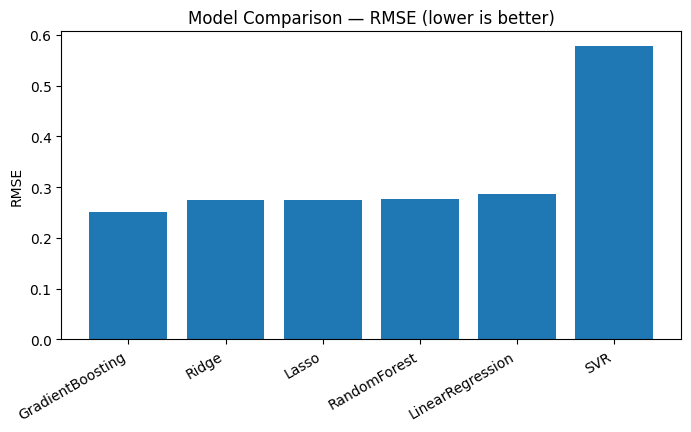

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(results_df["Model"], results_df["RMSE"])
plt.xticks(rotation=30, ha='right')
plt.ylabel("RMSE")
plt.title("Model Comparison — RMSE (lower is better)")
plt.show()

### Step 5.5 — Pick Best Model & Inspect Errors
We select the best model (lowest RMSE), inspect a few predictions vs actuals, and compute residual stats.


In [41]:
# Select best model by RMSE
best_row = results_df.iloc[0]
best_name = best_row["Model"]
best_model = fitted_models[best_name]

print(f"Best model: {best_name}")
y_pred_best = best_model.predict(X_test)

# Residual analysis
residuals = y_test - y_pred_best
print("Residuals — mean:", residuals.mean(), " std:", residuals.std())

# Show a small comparison table
compare_df = pd.DataFrame({
    "Actual": y_test.values[:25],
    "Predicted": y_pred_best[:25]
})
compare_df.reset_index(drop=True)



Best model: GradientBoosting
Residuals — mean: 0.008654549672936543  std: 0.2510133076716593


,Actual,Predicted
0,-0.236869,0.236503
1,-0.899655,-1.010275
2,0.285995,0.208642
3,-0.787718,-0.774361
4,-0.752369,-0.812327
5,-0.042599,-0.094530
6,0.337545,-0.074203
7,-0.420976,-0.411020
8,-1.301008,-1.365674
9,2.392181,2.495427


<Axes: >

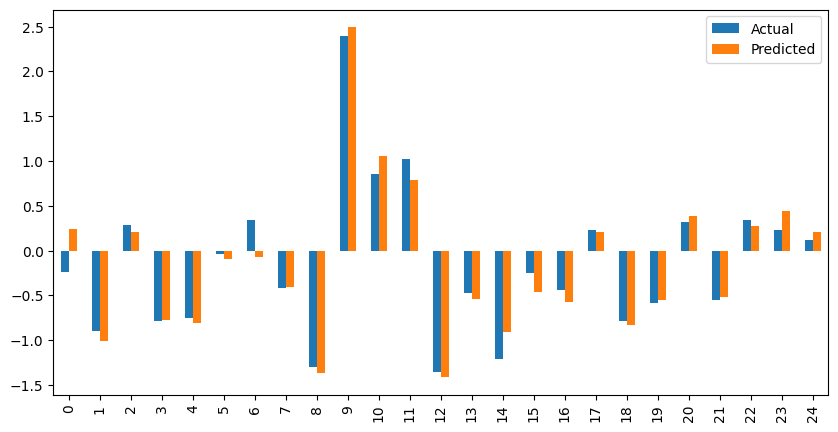

In [42]:
compare_df.plot(kind='bar', figsize=(10,5))

### Step 5.6 — Discussion & Analysis
- **Accuracy**: Compare models by RMSE/MAE; lower values indicate better predictions in SalePrice units.  
- **Generalization**: Check **R²** (closer to 1 is better) and residual statistics to assess fit and bias.  
- **Trade-offs**: Tree ensembles (RandomForest/GradientBoosting) typically capture non-linearities and interactions well; linear models (Ridge/Lasso) are simpler, faster, and more interpretable. SVR can perform well with careful kernel/parameter tuning on scaled features.  
- **Next Steps**: Consider hyperparameter tuning (GridSearchCV/RandomizedSearchCV), feature importance/SHAP analysis, and robust CV (KFold/StratifiedKFold over neighborhoods or groups if applicable).
